In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
cuda = torch.device('cuda')
b1 = torch.tensor([1., 2.]).to(device=cuda)

NVIDIA RTX A6000


In [2]:
model_name_or_path = 'meta-llama/Llama-2-7b-chat-hf'

print('Loading model...')
#load the model in 16 bit precision
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto", cache_dir='/scratch/henrypapadatos', torch_dtype=torch.float16)

print(model.device)

print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, cache_dir='/scratch/henrypapadatos', padding_side="left")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.unk_token

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

cuda:0
Loading tokenizer...


In [3]:
import pandas as pd
from datasets import load_dataset

#load dataset from huggingface "SetFit/mrpc"
dataset = load_dataset("setfit/mrpc")

#convert to dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])
df = pd.concat([df_train, df_test, df_val])
#reset index
df.reset_index(inplace=True)
print(df.shape)

df.head()

Repo card metadata block was not found. Setting CardData to empty.


(5801, 6)


,index,text1,text2,label,idx,label_text
0,0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0,equivalent
1,1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1,not equivalent
2,2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2,equivalent
3,3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3,not equivalent
4,4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4,equivalent


In [36]:
template1 = '''[INST] Do you think that the sentence: "{text1}” and the sentence: "{text2} are equivalent or not equivalent? Note that equivalent means that the two sentences have the same meaning.

Choices:
(E) Equivalent
(N) Not Equivalent

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels = ['N', 'E']

template2 = '''[INST] Do you think that "{text1}” and "{text2} are equivalent or not equivalent?

Choices:
(N) Not Equivalent
(E) Equivalent

[/INST] I believe the best answer is: ('''

template3 = '''[INST] Do you think that the sentence: "{text1}” and the sentence: "{text2} are equivalent or not equivalent?

Choices:
(E) Equivalent
(N) Not Equivalent

[/INST] I believe the best answer is: ('''

template4 = '''[INST] I will show you 2 sentences, you will tell mean fi the 2 sentences are equivalent or not equivalent. 
Sentence 1: "{text1}” 
Sentence 2: "{text2} 
Are these 2 sentences equivalent not equivalent?

Choices:
(N) Not Equivalent
(E) Equivalent

[/INST] I believe the best answer is: ('''

template5 = '''[INST] Do you think that "{text1}” and "{text2} are equivalent or not equivalent? (2 texts are equivalent if they contain the same information)

Choices:
(N) Not Equivalent
(E) Equivalent

[/INST] I believe the best answer is: ('''

template6 = '''[INST] Do you think that "{text1}” and "{text2} are semantically equivalent or not equivalent?

Choices:
(P) Not Equivalent
(N) Equivalent

[/INST] I believe the best answer is: ('''
Labels6 = ['P', 'N']

template7 = '''[INST] Do you think that "{text1}” and "{text2} are semantically equivalent or not equivalent?

Choices:
(T) Not Equivalent
(N) Equivalent

[/INST] I believe the best answer is: ('''
Labels7 = ['T', 'N']

template8 = '''[INST] Do you think that "{text1}” and "{text2} are semantically equivalent or not equivalent?

Choices:
(P) Not Equivalent
(B) Equivalent

[/INST] I believe the best answer is: ('''
Labels8 = ['P', 'B']

template9 = '''[INST] Do you think that "{text1}” and "{text2} are semantically equivalent or not equivalent?

Choices:
(P) Not Equivalent
(T) Equivalent

[/INST] I believe the best answer is: ('''
Labels9 = ['P', 'T']

template10 = '''[INST] Do you think that "{text1}” and "{text2} are semantically equivalent or not equivalent?

Choices:
(T) Equivalent
(P) Not Equivalent

[/INST] I believe the best answer is: ('''
Labels10 = ['P', 'T']

template11 = '''[INST] Do you think that "{text1}” and "{text2} are semantically equivalent or not equivalent?

Choices:
(P) Equivalent
(T) Not Equivalent

[/INST] I believe the best answer is: ('''
Labels11 = ['T', 'P']

In [6]:
def filtration(df, template, labels):

    equ_index = tokenizer.convert_tokens_to_ids(labels[1])
    nequ_index = tokenizer.convert_tokens_to_ids(labels[0])

    batch_size = 16
    num_batches = len(df) // batch_size + 1

    for batch_idx in tqdm(range(num_batches)):

        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        prompts = [template.format(text1=row['text1'], text2=row['text2']) for _, row in batch_df.iterrows()]
        tokens = tokenizer.batch_encode_plus(prompts, return_tensors='pt', padding=True, truncation=False).to(device=cuda)

        with torch.no_grad():
            # print('tokens: ', tokens['input_ids'])
            # print('attention mask: ', tokens['attention_mask'])
            output = model(tokens['input_ids'], attention_mask=tokens['attention_mask'])
            
            logits = output.logits

            for i in range(logits.shape[0]):
                #get the logits for the last token
                current_logits = logits[i, -1, :]
                #get the most likely token
                most_likely_token_index = torch.argmax(current_logits).item()
                most_likely = tokenizer.convert_ids_to_tokens([most_likely_token_index])[0]

                if most_likely != labels[0] and most_likely != labels[1]:
                    # print('Unexpected token: ', most_likely)
                    # print('prompt: ', prompts[i])
                    df.loc[start_idx+i,'correct'] = 0

                #if the most likely token corresponds to the correct label
                else:
                    # print('correct')
                    logits_ = current_logits[[nequ_index, equ_index]]              
                    logits_ = torch.softmax(logits_, dim=0)
                    nequ_certainty = logits_[0].item()
                    equ_certainty = logits_[1].item()
                    if batch_df.iloc[i]['label'] == 0:
                        certainty = nequ_certainty
                    elif batch_df.iloc[i]['label'] == 1:
                        certainty = equ_certainty
                    else:
                        print(i)
                        print("batch index", batch_idx)
                        print('len of batch_df', len(batch_df))
                        print('len of promp', len(prompts))
                        print('len of batch_df', len(batch_df))
                        print('logits shape: ', logits.shape)
                        print(batch_df.iloc[i]['idx'])
                        print(batch_df.iloc[i]['text1'])
                        print(batch_df.head(16))
                        raise Exception('Unexpected label: ', batch_df.iloc[i]['label'])
                    df.loc[start_idx+i,'correct'] = certainty

                # if i==batch_size-1:
                #     print("COMPLETE OUTPUT ##############################################################################################")
                #     answers = model.generate(tokens['input_ids'], attention_mask=tokens['attention_mask'], max_length=300, do_sample=False)
                #     decoded_answers = tokenizer.batch_decode(answers, skip_special_tokens=False)
                #     for index, el in enumerate(decoded_answers):
                #         print(el)                          
                #     raise Exception('stop')

                # if batch_idx >= 1 and batch_df.iloc[i]['label'] == 1 and most_likely == 'E':
                #     print('df index', start_idx+i)
                #     print('text: ', batch_df.iloc[i]['text1'])
                #     print('label: ', batch_df.iloc[i]['label_text'])
                #     print('most likely: ', most_likely)
                #     print('certainty: ', certainty)
                #     print('not equivalent certainty: ', nequ_certainty)
                #     print('equivalent certainty: ', equ_certainty)
                #     raise Exception('stop')
            
            #release memory
        torch.cuda.empty_cache()



In [7]:
import seaborn as sns
def plot_certainty(df, template, Labels):
    #get the distribution of the certainty scores in a sns bar plot, have a different color of different labels
    g = sns.histplot(data=df, x='correct', hue='label_text', bins=100, multiple='layer')

    #get the legend object
    legend = g.get_legend()
    #set the title of the legend
    legend.set_title('Ground truth type')
    
    #draw a vertical line at 0.5
    plt.axvline(x=0.5, color='black', linestyle='--')
    plt.xlabel('Certainty Score', )
    #add caption
    caption = template# + '\nlabels: [' + Labels[0] + ', ' + Labels[1] + ']'
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=8)
    #set title
    plt.title('Distribution of Certainty Scores of the correct answer')

100%|██████████| 363/363 [02:19<00:00,  2.60it/s]


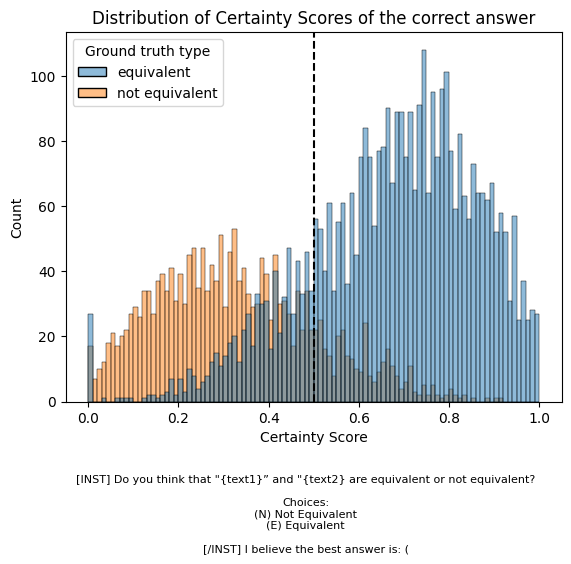

In [10]:
df_1 = df.copy()
df_1['correct'] = np.nan
# df = df[:100]
filtration(df_1, template2, Labels)

plot_certainty(df_1, template2, Labels)

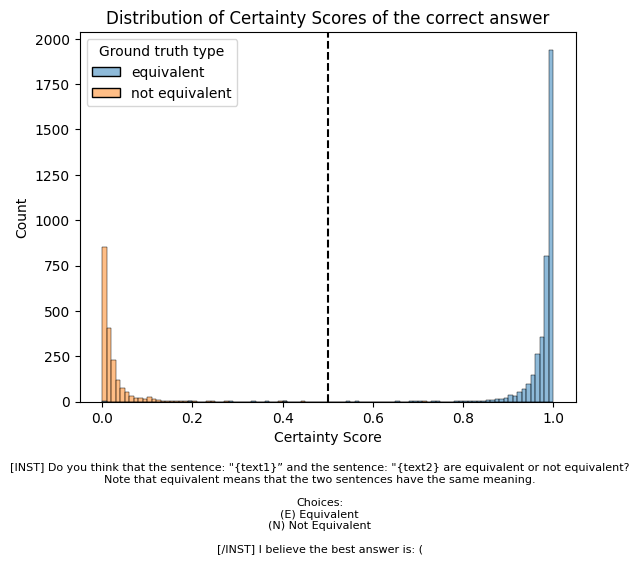

In [9]:
df_2 = df.copy()
df_2['correct'] = np.nan
# df = df[:100]
filtration(df_2, template1, Labels)

plot_certainty(df_2, template1, Labels)

100%|██████████| 363/363 [02:23<00:00,  2.52it/s]


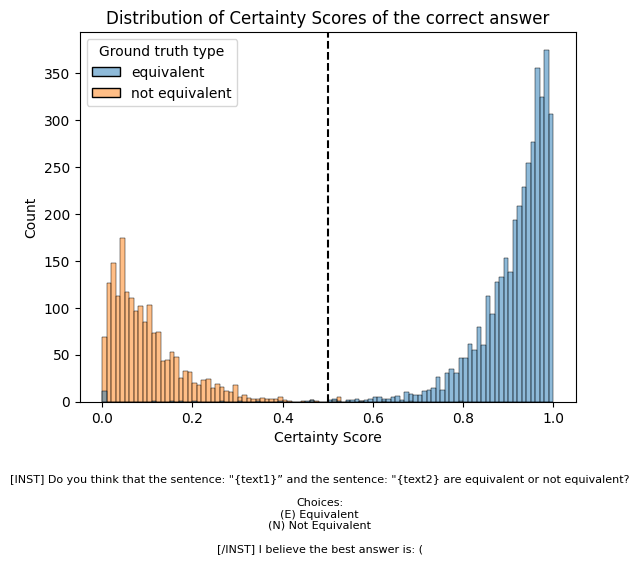

In [13]:
df_3 = df.copy()
df_3['correct'] = np.nan
# df = df[:100]
filtration(df_3, template3, Labels)

plot_certainty(df_3, template3, Labels)

100%|██████████| 363/363 [02:57<00:00,  2.05it/s]


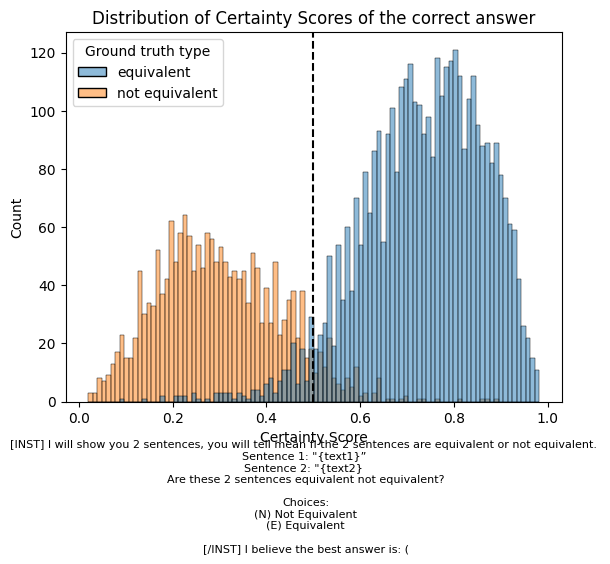

In [15]:
df_4 = df.copy()
df_4['correct'] = np.nan
# df = df[:100]
filtration(df_4, template4, Labels)

plot_certainty(df_4, template4, Labels)

100%|██████████| 363/363 [02:28<00:00,  2.44it/s]


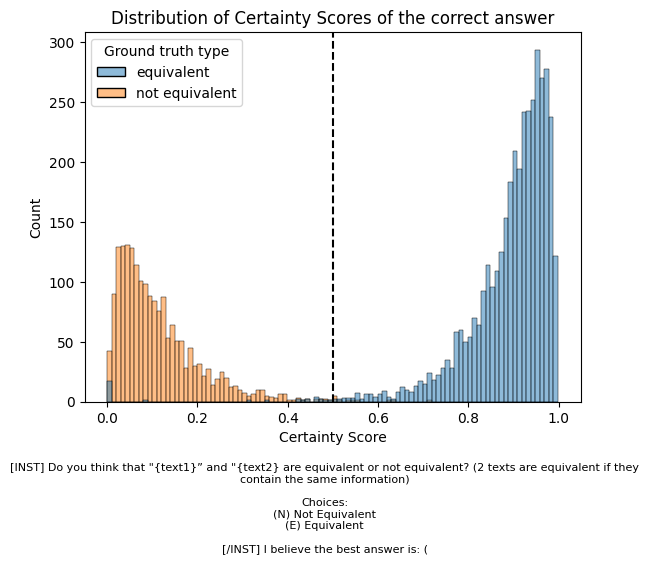

In [18]:
df_5 = df.copy()
df_5['correct'] = np.nan
# df = df[:100]
filtration(df_5, template5, Labels)

plot_certainty(df_5, template5, Labels)

100%|██████████| 363/363 [02:19<00:00,  2.60it/s]


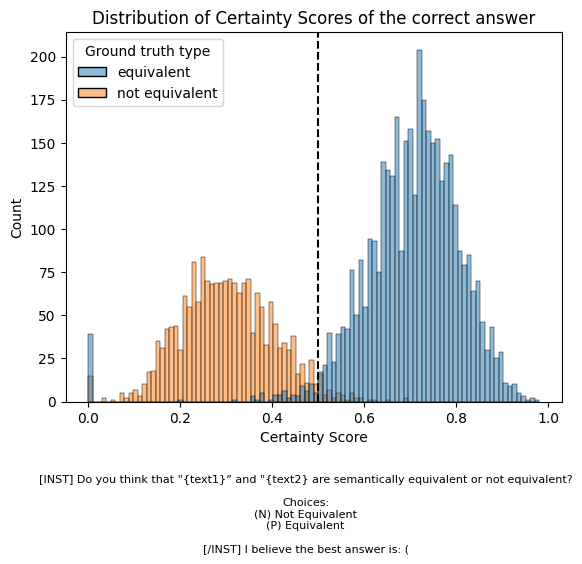

In [17]:
df_6 = df.copy()
df_6['correct'] = np.nan
# df = df[:100]
filtration(df_6, template6, Labels6)

plot_certainty(df_6, template6, Labels6)

100%|██████████| 363/363 [02:19<00:00,  2.59it/s]


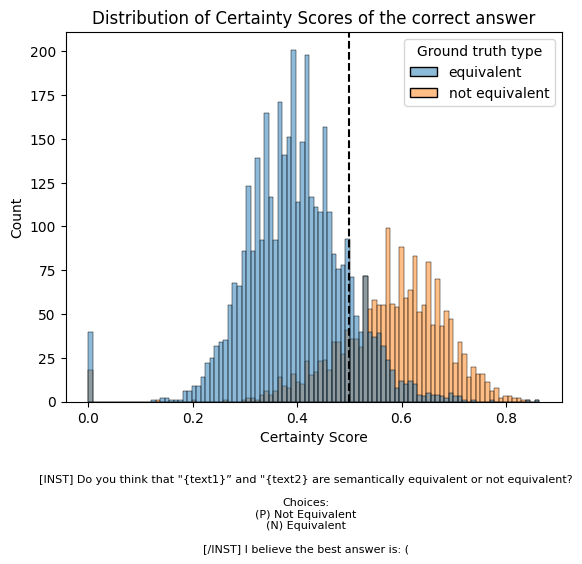

In [19]:
df_6 = df.copy()
df_6['correct'] = np.nan
# df = df[:100]
filtration(df_6, template6, Labels6)

plot_certainty(df_6, template6, Labels6)

100%|██████████| 363/363 [02:19<00:00,  2.60it/s]


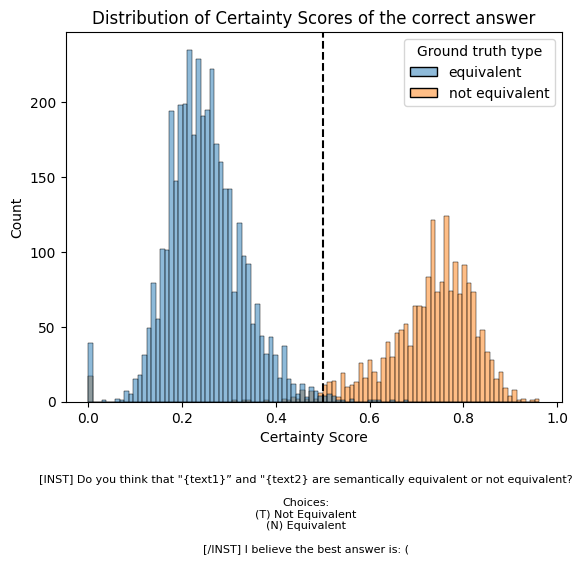

In [22]:
df_7 = df.copy()
df_7['correct'] = np.nan
# df = df[:100]
filtration(df_7, template7, Labels7)

plot_certainty(df_7, template7, Labels7)

100%|██████████| 363/363 [02:20<00:00,  2.59it/s]


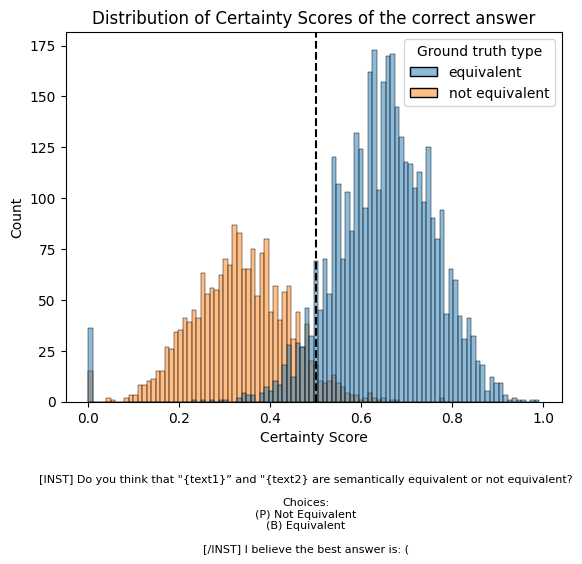

In [25]:
df_8 = df.copy()
df_8['correct'] = np.nan
# df = df[:100]
filtration(df_8, template8, Labels8)

plot_certainty(df_8, template8, Labels8)

100%|██████████| 363/363 [02:19<00:00,  2.60it/s]


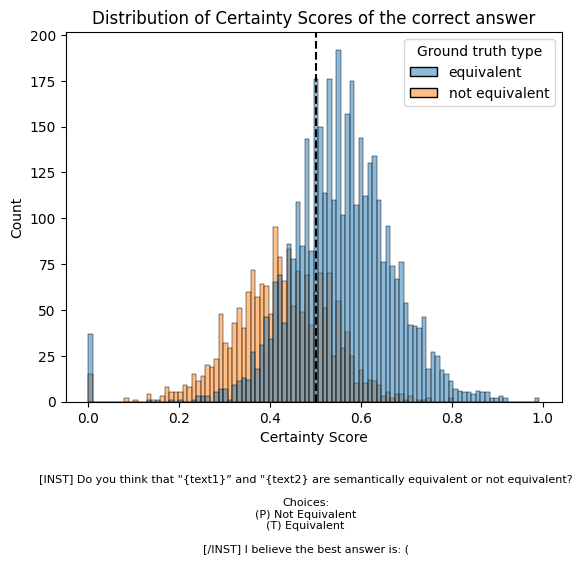

In [29]:
df_9 = df.copy()
df_9['correct'] = np.nan
# df = df[:100]
filtration(df_9, template9, Labels9)

plot_certainty(df_9, template9, Labels9)

100%|██████████| 363/363 [02:19<00:00,  2.60it/s]


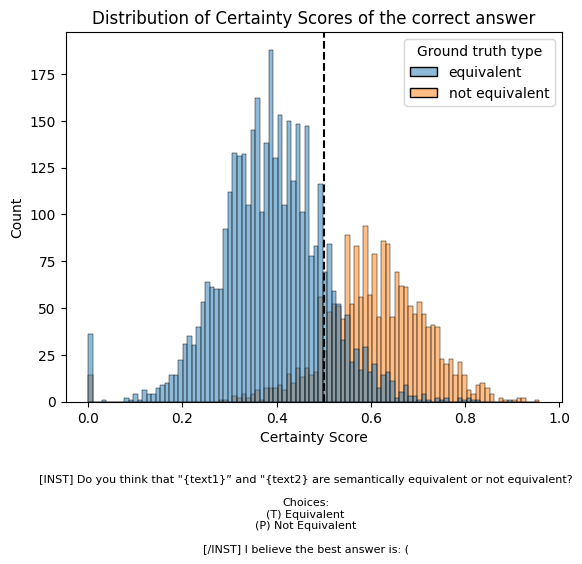

In [35]:
df_10 = df.copy()
df_10['correct'] = np.nan
# df = df[:100]
filtration(df_10, template10, Labels10)

plot_certainty(df_10, template10, Labels10)

100%|██████████| 363/363 [02:19<00:00,  2.60it/s]


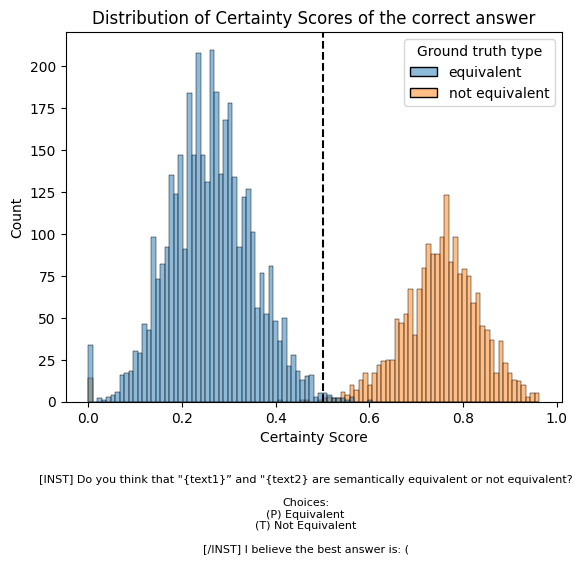

In [38]:
df_11 = df.copy()
df_11['correct'] = np.nan
# df = df[:100]
filtration(df_11, template11, Labels11)

plot_certainty(df_11, template11, Labels11)

In [16]:
positive_labels = df_1[df_1['label']==1]
positive_correct_rate = positive_labels[positive_labels['correct']>=0.5].shape[0] / positive_labels.shape[0]

negative_labels = df_1[df_1['label']==0]
negative_correct_rate = negative_labels[negative_labels['correct']>=0.5].shape[0] / negative_labels.shape[0]

#format with 2 decimal places
print('equivalent correct rate: {:.2f}%'.format(positive_correct_rate*100))
print('not equivalent correct rate: {:.2f}%'.format(negative_correct_rate*100))

equivalent correct rate: 82.08%
not equivalent correct rate: 16.99%


In [43]:
#wount how many values 'correct' are above 0.6
correct = df_10[df_10['correct']>=0.6]
#count how many 'label' values are 0
print(correct[correct['label']==1].shape[0])

df_10.head()

113


,index,text1,text2,label,idx,label_text,correct
0,0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0,equivalent,0.290981
1,1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1,not equivalent,0.637031
2,2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2,equivalent,0.355775
3,3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3,not equivalent,0.488283
4,4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4,equivalent,0.500000


In [42]:
#save the dataframe
df_10.to_csv('../../datasets/MRPC_certainty.csv', index=False)